In [1]:
#### import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171133 entries, 0 to 171132
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171133 non-null  object 
 1   song                      171133 non-null  object 
 2   text                      171123 non-null  object 
 3   emotion                   171133 non-null  object 
 4   Tempo                     171133 non-null  int64  
 5   Loudness (db)             171133 non-null  float64
 6   Energy                    171133 non-null  int64  
 7   Danceability              171133 non-null  int64  
 8   Positiveness              171133 non-null  int64  
 9   Speechiness               171133 non-null  int64  
 10  Liveness                  171133 non-null  int64  
 11  Acousticness              171133 non-null  int64  
 12  Instrumentalness          171133 non-null  int64  
 13  Good for Party            171133 non-null  i

In [4]:
# Fully numeric artist names
fully_numeric = data['Artist(s)'][data['Artist(s)'].str.fullmatch(r'\d+')]
print("🎤 Fully numeric artist names:", fully_numeric.unique().tolist())

🎤 Fully numeric artist names: ['112', '1814', '311']


In [5]:
data['Artist(s)'] = data['Artist(s)'].astype(str).str.lower().str.strip()
data['Artist(s)'] = data['Artist(s)'].str.replace(r'\$', 's', regex=True)
data['Artist(s)'] = data['Artist(s)'].str.replace('4', 'a')

In [6]:
data['Artist(s)'].value_counts()

Artist(s)
lab                         1427
temm dogg                    701
kora                         670
shapeshifter                 640
home brew                    606
                            ... 
selah                         50
6 dogs                        50
mudvayne                      50
yeat                          50
unknown mortal orchestra      49
Name: count, Length: 1578, dtype: int64

In [7]:
data['Artist(s)'].isnull().sum()

np.int64(0)

In [8]:
data.dropna(inplace=True)
data.reset_index(drop = True, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171123 entries, 0 to 171122
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171123 non-null  object 
 1   song                      171123 non-null  object 
 2   text                      171123 non-null  object 
 3   emotion                   171123 non-null  object 
 4   Tempo                     171123 non-null  int64  
 5   Loudness (db)             171123 non-null  float64
 6   Energy                    171123 non-null  int64  
 7   Danceability              171123 non-null  int64  
 8   Positiveness              171123 non-null  int64  
 9   Speechiness               171123 non-null  int64  
 10  Liveness                  171123 non-null  int64  
 11  Acousticness              171123 non-null  int64  
 12  Instrumentalness          171123 non-null  int64  
 13  Good for Party            171123 non-null  i

#### 4.2 **Power Transformer for Skewed Audio Features**

* we need to apply power transformer to the heavily skewed features like `instrumentalness`, `liveness`, `speechiness`, `loudness (db)` and `acousticness`.

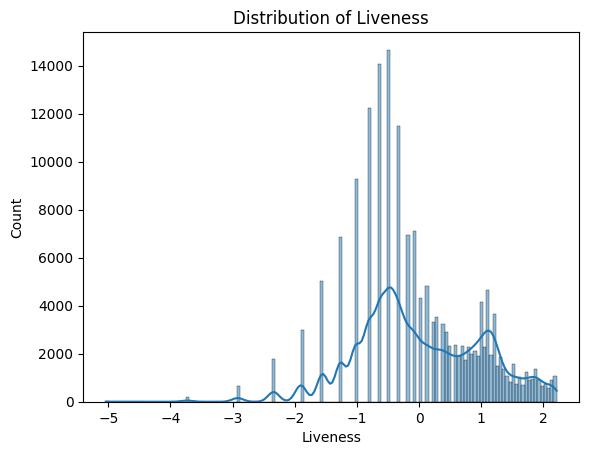

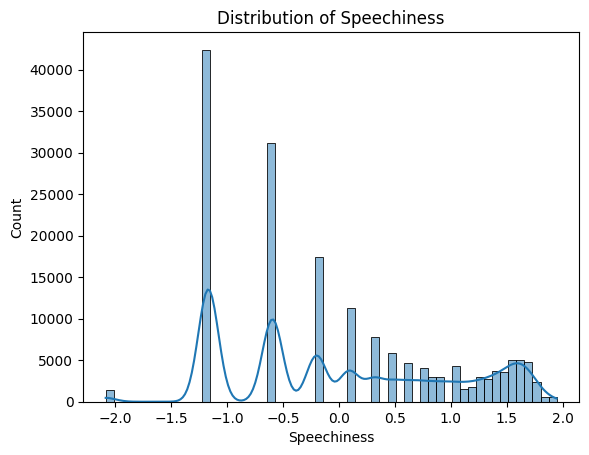

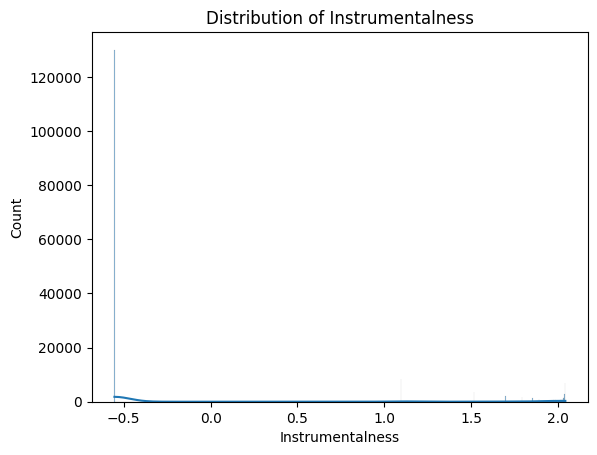

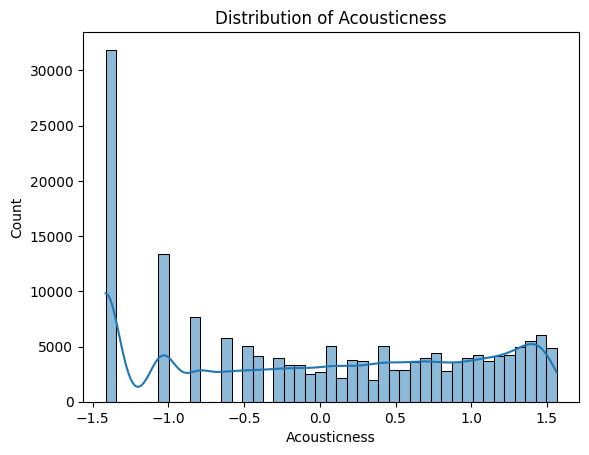

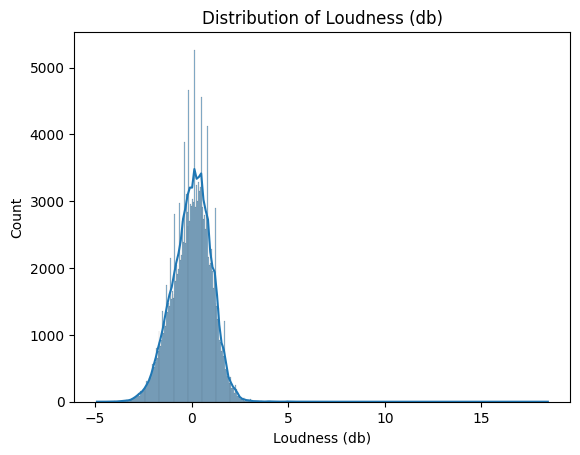

In [10]:
#### Applying power transformer to the skewed audio features.
pt = PowerTransformer(method='yeo-johnson')

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']

scaled_audio = pt.fit_transform(data[cols_to_transform])
data[cols_to_transform] = scaled_audio

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']
for feature in cols_to_transform:
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

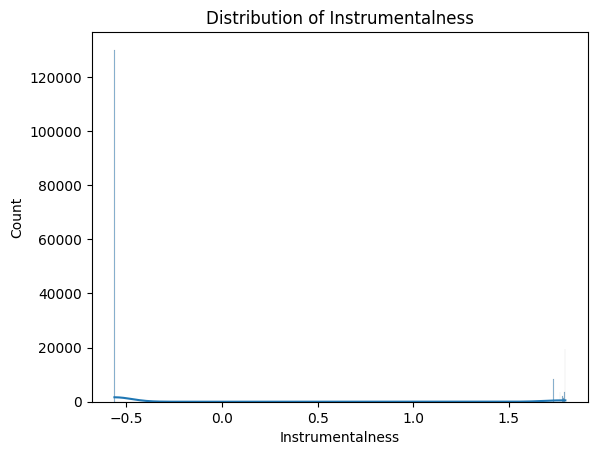

In [11]:
# apply log1p to instrumentalness first 
data[['Instrumentalness']] = np.log1p(data[['Instrumentalness']])

pt = PowerTransformer()
data[['Instrumentalness']] = pt.fit_transform(data[['Instrumentalness']])


sns.histplot(data['Instrumentalness'], kde=True)
plt.title(f'Distribution of Instrumentalness')
plt.show()

* Even after applying `log1p` and `power transformer` it doesn't change anything. so i will keep `Instrumentalness` as it is.

#### 4.3 **TF-IDF on text Columns**

In [12]:
### Applying tf-idf on text columns 
data['combined_text'] = (
    data['text'] + " " +
    data['emotion'] + " " +
    data['Genre_str'] + " " +
    data['Artist(s)']
)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english') 
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

In [13]:
similar_context_series = (
    data['Similar Artist 1']+ ' ' +
    data['Similar Artist 2']+ ' ' +
    data['Similar Artist 3']+ ' ' +
    data['Similar Song 1']+ ' ' +
    data['Similar Song 2']+ ' ' +
    data['Similar Song 3']
)

tfidf_similar = TfidfVectorizer(max_features=5000, stop_words="english")
similar_vectors = tfidf_similar.fit_transform(similar_context_series)

#### 4.4 **Combine TF-IDF & Scaled Audio features**

In [14]:
### Checking the shape od the tfidf matrix and scaled audio 
print(tfidf_matrix.shape[0], similar_vectors[0], scaled_audio.shape[0]) 

171123 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 4801)	0.5002195081336668
  (0, 118)	0.46909322025689254
  (0, 4945)	0.518204732028466
  (0, 2314)	0.24830022679843639
  (0, 3262)	0.276530978464527
  (0, 1742)	0.19448695743357458
  (0, 2299)	0.250932824419748
  (0, 3617)	0.14926823651765914 171123


In [15]:
from scipy.sparse import hstack

# Combine into one final feature set for cosine similarity
final_matrix = hstack([tfidf_matrix, similar_vectors, scaled_audio])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171123 entries, 0 to 171122
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171123 non-null  object 
 1   song                      171123 non-null  object 
 2   text                      171123 non-null  object 
 3   emotion                   171123 non-null  object 
 4   Tempo                     171123 non-null  int64  
 5   Loudness (db)             171123 non-null  float64
 6   Energy                    171123 non-null  int64  
 7   Danceability              171123 non-null  int64  
 8   Positiveness              171123 non-null  int64  
 9   Speechiness               171123 non-null  float64
 10  Liveness                  171123 non-null  float64
 11  Acousticness              171123 non-null  float64
 12  Instrumentalness          171123 non-null  float64
 13  Good for Party            171123 non-null  i

#### **4.5 Handle User Query Input**

In [17]:
data['emotion'].unique()

array(['joy', 'anger', 'sadness', 'fear', 'surprise', 'love'],
      dtype=object)

In [18]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")

# Define allowed dataset moods
available_moods = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'love']

# Mapping user moods to dataset moods
mood_map = {
    'happy': 'joy',
    'calm': 'love',
    'relaxed': 'joy',
    'peaceful': 'joy',
    'romantic': 'love',
    'chill': 'joy',
    'energetic': 'surprise',
    'excited': 'surprise',
    'angry': 'anger',
    'depressed': 'sadness',
    'bored': 'sadness',
    'sad': 'sadness',
    'fearful': 'fear'
}

def extract_mood_artist_spacy(user_input, known_artists):
    doc = nlp(user_input.lower())
    user_input_lower = user_input.lower()

    # 1. Detect mood
    mood = ""
    for word in user_input_lower.split():
        if word in mood_map:
            mood = mood_map[word]
            break
        elif word in available_moods:
            mood = word
            break

    # 2. Detect artist
    artist = ""
    for known_artist in known_artists:
        pattern = r'\b' + re.escape(known_artist) + r'\b'
        if re.search(pattern, user_input_lower):
            artist = known_artist
            break

    return mood, artist


In [31]:
known_artists = data['Artist(s)'].str.lower().str.strip().unique().tolist()

user_input = "I'm feeling sad give me songs froM home brew artist"
mood, artist = extract_mood_artist_spacy(user_input, known_artists)

print("Mapped mood:", mood)    
print("Artist:", artist) 

Mapped mood: sadness
Artist: home brew


In [20]:
# Fully numeric artist names
fully_numeric = data['Artist(s)'][data['Artist(s)'].str.fullmatch(r'\d+')]
print("🎤 Fully numeric artist names:", fully_numeric.unique().tolist())

🎤 Fully numeric artist names: ['112', '311']


In [21]:
data['Artist(s)'].unique()

array(['weird al yankovic', 'uicideboy', 'nsync', ..., 'zayn',
       'zebrahead', 'zz top'], shape=(1578,), dtype=object)

In [22]:
data['Artist(s)'] = data['Artist(s)'].str.lower().str.strip()

#### **5.Building Recommendation Logic Using Cosine Similarity**

In [23]:
### Create Similar Song Dictionary
from collections import defaultdict

similar_song = defaultdict(dict)

for idx, row in data.iterrows():
    base_song = row['song'].strip().lower()
    for i in range(1,4):
        sim_song = row[f'Similar Song {i}']
        sim_score = row[f'Similarity Score {i}']
        if pd.notnull(sim_song):
            similar_song[base_song][sim_song.strip().lower()] = sim_score

In [24]:
data['Artist(s)'].value_counts()

Artist(s)
lab                         1427
temm dogg                    701
kora                         670
shapeshifter                 640
home brew                    606
                            ... 
selah                         50
6 dogs                        50
mudvayne                      50
yeat                          50
unknown mortal orchestra      49
Name: count, Length: 1578, dtype: int64

In [25]:
data['Artist(s)'].unique()

array(['weird al yankovic', 'uicideboy', 'nsync', ..., 'zayn',
       'zebrahead', 'zz top'], shape=(1578,), dtype=object)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack


def get_recommendations(user_input, top_n=5):
    # Extract mood and artist using spaCy
    mood, artist = extract_mood_artist_spacy(user_input, known_artists)

    # Detect activity 
    activity_map = {
        "party": "Good for Party",
        "reading": "Good for Work/Study",
        "study": "Good for Work/Study",
        "exercise": "Good for Exercise",
        "running": "Good for Running",
        "driving": "Good for Driving",
        "morning": "Good for Morning Routine",
        "relaxation": "Good for Relaxation/Yoga",
        "yoga": "Good for Relaxation/Yoga",
        "meditation": "Good for Relaxation/Yoga"
    }

    activity_col = ""
    for key, col in activity_map.items():
        if key in user_input.lower():
            activity_col = col
            break

    # TF-IDF vector for mood + input text
    search_text = f"{mood} {user_input}" if mood else user_input
    mood_vector = tfidf.transform([search_text])

    sim_context_input = artist if artist else mood or user_input
    sim_context_vector = tfidf_similar.transform([sim_context_input])
    
    avg_audio_vec = np.mean(scaled_audio, axis=0).reshape(1, -1)

    # 2. Stack them
    user_vector = hstack([mood_vector, sim_context_vector, avg_audio_vec])

    # 3. Compute similarity
    final_scores = cosine_similarity(user_vector, final_matrix).flatten()

    # Apply optional activity column filter
    if activity_col:
        activity_mask = data[activity_col] == 1
        final_scores *= activity_mask.astype(int).values

    # Boost scores of songs from the mentioned artist
    if artist:
        artist_mask = data['Artist(s)'].str.lower() == artist.lower()
        final_scores += artist_mask.astype(int).values * 0.75  

   # Get top N recommended songs (main DataFrame)
    top_indices = final_scores.argsort()[::-1][:top_n]
    results = data.iloc[top_indices][['song', 'Artist(s)', 'emotion', 'Genre_str']].copy()
    results['similarity_score'] = final_scores[top_indices]

    # Collect similar songs and artists from top recommendations
    all_similar_songs = set()
    all_similar_artists = set()

    for _, row in results.iterrows():
        song = row['song']
        original_artist = row['Artist(s)'].strip().lower()

        song_key = song.strip().lower()

        # Get similar song
        sim_song = list(similar_song.get(song_key, {}).keys())[:3]
        all_similar_songs.update(sim_song)

        # Genre-based similar artists
        song_genres = row['Genre_str'].split()
        genre_mask = data['Genre_str'].apply(lambda x: any(g in x.split() for g in song_genres))

        exclude_artists = {original_artist}
        if artist:
            exclude_artists.add(artist.strip().lower())

        candidate_artists = data[genre_mask]['Artist(s)'].str.lower().unique().tolist()
        filtered_artists = [a for a in candidate_artists if a not in exclude_artists]

        all_similar_artists.update(filtered_artists[:10])  

    # Final top 5 unique similar songs and artists
    final_similar_songs = list(all_similar_songs)[:5]
    final_similar_artists = list(all_similar_artists)[:5]

    return results, final_similar_songs, final_similar_artists

In [27]:
user_input = "songs from temm dogg"
recommendations_df, similar_songs, similar_artists = get_recommendations(user_input)

print("\n Final Recommendations:")
print(recommendations_df)

print("\n Top 5 Similar Songs:")
for s in similar_songs:
    print(f" * {s}")

print("\n Top 5 Similar Artists:")
for a in similar_artists:
    print(f" * {a}")


 Final Recommendations:
                                  song  Artist(s) emotion  \
139228                     Huggy Wuggy  temm dogg     joy   
139283             Batgang / Black Tee  temm dogg   anger   
139817                    220 EP Intro  temm dogg     joy   
139807  Freestyle on Arsenio Hall Show  temm dogg     joy   
139808                     Cheese Cake  temm dogg     joy   

                   Genre_str  similarity_score  
139228  hiphop hiphop reggae          1.205899  
139283  hiphop hiphop reggae          1.198469  
139817  hiphop hiphop reggae          1.172435  
139807  hiphop hiphop reggae          1.171548  
139808  hiphop hiphop reggae          1.145608  

 Top 5 Similar Songs:
 * on watch
 * batman
 * reason to stay
 * just like the mob
 * commotion

 Top 5 Similar Artists:
 * 112
 * uicideboy
 * 5o cent
 * 311
 * 181a


In [28]:
data['Artist(s)'].value_counts()

Artist(s)
lab                         1427
temm dogg                    701
kora                         670
shapeshifter                 640
home brew                    606
                            ... 
selah                         50
6 dogs                        50
mudvayne                      50
yeat                          50
unknown mortal orchestra      49
Name: count, Length: 1578, dtype: int64

* Instead of strictly relying on emotion labels (e.g., joy, sadness), similar songs are recommended based on lyrical similarity using TF-IDF and cosine similarity. This allows the system to capture songs whose lyrics align more closely with the user’s mood, even if the labeled emotion differs.